In [1]:
import numpy as np
import pandas as pd

In [2]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Using TensorFlow backend.
/Users/naoki/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/naoki/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/naoki/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/naoki/opt/anaconda3/lib/python3.7/sit

In [3]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
X_train = X_train/255.0
X_test = X_test/255.0
X_test.shape

(10000, 784)

In [4]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) 
print(y_test_one_hot.shape)

(60000,)
(60000, 10)
float64
(10000, 10)


 # 【問題1】全結合層のクラス化
全結合層のクラス化を行なってください。

以下に雛形を載せました。コンストラクタで重みやバイアスの初期化をして、あとはフォワードとバックワードのメソッドを用意します。重みW、バイアスB、およびフォワード時の入力Xをインスタンス変数として保持しておくことで、煩雑な入出力は不要になります。

なお、インスタンスも引数として渡すことができます。そのため、初期化方法のインスタンスinitializerをコンストラクタで受け取れば、それにより初期化が行われます。渡すインスタンスを変えれば、初期化方法が変えられます。

また、引数として自身のインスタンスselfを渡すこともできます。これを利用してself.optimizer.update(self)という風に層の重みの更新が可能です。更新に必要な値は複数ありますが、全て全結合層が持つインスタンス変数にすることができます。

初期化方法と最適化手法のクラスについては後述します。

In [5]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練用データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [6]:
get_mini_batch = GetMiniBatch(X_train, y_train_one_hot, batch_size=20)
for mini_X_train, mini_y_train in get_mini_batch:
    mini_X_train, mini_y_train

In [7]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.initializer = initializer

        self.W = self.initializer.W(self.n_nodes1, self.n_nodes2)
        self.B = self.initializer.B(self.n_nodes2)
        
        self.h_w = None
        self.h_b = None
        
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
    
    
    
    def forward(self, X,):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """   
        self.Z = X 
        self.A = self.Z @ self.W + self.B

        return self.A
        

    
    
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        # 更新
        self.dB = np.sum(dA, axis=0)
        self.dW = self.Z.T @ dA
        dZ = dA @ self.W.T
        
        self = self.optimizer.update(self)
        return dZ

# 【問題2】初期化方法のクラス化
初期化を行うコードをクラス化してください。

前述のように、全結合層のコンストラクタに初期化方法のインスタンスを渡せるようにします。以下の雛形に必要なコードを書き加えていってください。標準偏差の値（sigma）はコンストラクタで受け取るようにすることで、全結合層のクラス内にこの値（sigma）を渡さなくてすむようになります。

これまで扱ってきた初期化方法はSimpleInitializerクラスと名付けることにします。

In [8]:
class SimpleInitializer:

    
    def __init__(self, sigma=0.01):
        self.sigma = sigma
        
        
    def W(self, n_nodes1, n_nodes2):
        np.random.seed(5)
        self.W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return self.W
    
    
    def B(self, n_nodes2):
        np.random.seed(5)
        self.B = self.sigma * np.random.randn(n_nodes2)
        return self.B

 # 【問題3】最適化手法のクラス化
最適化手法のクラス化を行なってください。

最適化手法に関しても初期化方法同様に全結合層にインスタンスとして渡します。バックワードのときにself.optimizer.update(self)のように更新できるようにします。以下の雛形に必要なコードを書き加えていってください。

これまで扱ってきた最適化手法はSGDクラス（Stochastic Gradient Descent、確率的勾配降下法）として作成します。

In [9]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr=0.001):
        self.lr = lr
        
    def update(self,layer):  #layer,
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """

        layer.W -= (self.lr * layer.dW)
        layer.B -= (self.lr * layer.dB)
        

 # 【問題4】活性化関数のクラス化
活性化関数のクラス化を行なってください。

ソフトマックス関数のバックプロパゲーションには交差エントロピー誤差の計算も含む実装を行うことで計算が簡略化されます。

In [10]:
def loss_fnk(target,pred):
    Loss = - np.sum(target * np.log(pred)) / target.shape[0]
    return Loss

In [11]:
class soft_max:
    
    def __init__(self):
        self.soft_max = 0
    
    def forward(self,data):
        
        if data.ndim == 2:
            data = data.T
            data = data - np.max(data, axis=0)
            self.soft_max = np.exp(data) / np.sum(np.exp(data), axis=0)
            return self.soft_max.T
        data = data - np.max(data)   # オーバーフロー対策
        self.soft_max = np.exp(data) / np.sum(np.exp(data))
        return self.soft_max

    def backward(self, target):
        self.dA = self.soft_max.T - target
        return self.dA

In [12]:
np.set_printoptions(edgeitems=10)
#print(np.unique(X_train))
sf = soft_max()
a = sf.forward(X_train)
print(np.sum(a,axis=1))


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ... 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [13]:
class sigmoid:
    
    
    def forward(self,data):
        C = np.max(data)
        self.sig = 1 / (1 + np.exp(-data/C))
        return self.sig
    
    
    def backward(self,dZ):
        self.sig_d = dZ * (1 - self.sig) * self.sig
        return self.sig_d

In [14]:
class tanh:
    
    
    def forward(self,data):
        C = np.max(data)
        self.t = np.tanh(data/C)
        return self.t
    
    
    def backward(self,A,dZ):
        C = np.max(A)
        B = A/C
        self.dA2 = dZ*(1-np.tanh(B))
        return self.dA2

# 【問題5】ReLUクラスの作成
現在一般的に使われている活性化関数であるReLU（Rectified Linear Unit）をReLUクラスとして実装してください。

ReLUは以下の数式です。

In [15]:
class ReLU():
    def __init__(self):
        self.mask = None
        
    def forward(self, x):
        self.mask = (x <= 0)
        self.A = x.copy()
        self.A[self.mask] = 0
        return self.A
        
    def backward(self, dA):
        dA[self.mask] = 0
        dA = dA
        return dA

 # 【問題6】重みの初期値
ここまでは重みやバイアスの初期値は単純にガウス分布で、標準偏差をハイパーパラメータとして扱ってきました。しかし、どのような値にすると良いかが知られています。シグモイド関数やハイパボリックタンジェント関数のときは Xavierの初期値 （またはGlorotの初期値）、ReLUのときは Heの初期値 が使われます。

XavierInitializerクラスと、HeInitializerクラスを作成してください。

In [16]:
class XavierInitializer:
    
    
    def W(self, n_node1, n_node2):
        self.sigma = (1 / np.sqrt(n_node1))
        np.random.seed(0)
        self.W = self.sigma * np.random.randn(n_node1, n_node2)
        return self.W
        
    def B(self,n_node2):
        np.random.seed(0)
        self.B = self.sigma * np.random.randn(n_node2)
        return self.B

In [17]:
class He:
    
    def W(self,  n_node1, n_node2):
        sigma = np.sqrt(2 / n_node1)
        np.random.seed(0)
        self.W = sigma * np.random.randn(n_node1, n_node2)
        return self.W
        
    def B(self,n_node2):
        sigma = np.sqrt(2 / n_node2)
        np.random.seed(0)
        self.B = sigma * np.random.randn(n_node2)
        return self.B

 # 【問題7】最適化手法
学習率は学習過程で変化させていく方法が一般的です。基本的な手法である AdaGrad のクラスを作成してください。

まず、これまで使ってきたSGDを確認します。

In [18]:
class AdaGrad():
    def __init__(self , lr , b_size):
        self.lr = lr
        self.b_size = b_size
    
    def update(self , layer):        
        layer.h_w += (layer.dW/self.b_size) * (layer.dW/self.b_size)
        layer.W -= self.lr * (layer.dW/self.b_size) / (np.sqrt(layer.h_w) + 1e-7)
        layer.h_b += (layer.dB/self.b_size) * (layer.dB/self.b_size)
        layer.B -= self.lr * (layer.dB/self.b_size) / (np.sqrt(layer.hb) + 1e-7)
        self.h_w = layer.h_w
        self.h_b = layer.h_b
        return layer.W, layer.B
    

 # 【問題8】クラスの完成
任意の構成で学習と推定が行えるScratchDeepNeuralNetrowkClassifierクラスを完成させてください。

In [19]:
class ScratchSimpleDNN():
    """
    シンプルな三層ニューラルネットワーク分類器

    Parameters
    ----------

    Attributes
    ----------
    """

    def __init__(self, 
                 batch_size=20, 
                 epoch=20, 
                 FC1 = FC(784,600,initializer=He(),optimizer=SGD(lr=0.01)),
                 FC2=FC(600,600,initializer=He(),optimizer=SGD(lr=0.01)),
                 FC3=FC(600,10,initializer=He(),optimizer=SGD(lr=0.01)),
                 activation1 = ReLU(),
                 activation2 = ReLU(),
                 activation_end = soft_max(),
                 verbose = True):
        
        
        self.verbose = verbose
        self.batch_size = batch_size
        self.Loss = 0
        self.epoch = epoch
        self.FC1 = FC1
        self.FC2 = FC2
        self.FC3 = FC3
        self.activation1 = activation1
        self.activation2 = activation2
        self.activation3 = activation_end
        
        
        
    def fit(self, data, target, test, target2):
        self.loss_list = []
        for i in range(self.epoch):
            print(i,"epoch")
            get_mini_batch = GetMiniBatch(data, target, batch_size=self.batch_size)
            for mini_X_train, mini_y_train in get_mini_batch:
                self.A1 = self.FC1.forward(mini_X_train)
                self.Z1 = self.activation1.forward(self.A1)

                self.A2 = self.FC2.forward(self.Z1)
                self.Z2 = self.activation2.forward(self.A2)

                self.A3 = self.FC3.forward(self.Z2)
                self.Z3 = self.activation3.forward(self.A3)
    
                self.A3_b = self.activation3.backward(mini_y_train)
                self.Z3_b = self.FC3.backward(self.A3_b)
                
                self.Z2_b = self.activation2.backward(self.Z3_b)
                self.A2_b = self.FC2.backward(self.Z2_b)
                
                self.Z1_b = self.activation1.backward(self.A2_b)
                self.A1_b = self.FC1.backward(self.Z1_b)
                
            
        
            A1 = self.FC1.forward(test)
            Z1 = self.activation1.forward(A1)
            A2 = self.FC2.forward(Z1)
            Z2 = self.activation2.forward(A2)
            A3 = self.FC3.forward(Z2)
            Z3 = self.activation3.forward(A3)
            print("Z3_max",np.argmax(Z3,axis=1))
            loss= loss_fnk(target2, Z3)
            self.loss_list.append(loss)
            
            
    def predict(self, data):
        
        A1 = self.FC1.forward(data)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        y_pred = np.argmax(Z3,axis=1)
        return y_pred

 # 【問題9】学習と推定
層の数や活性化関数を変えたいくつかのネットワークを作成してください。そして、MNISTのデータを学習・推定し、Accuracyを計算してください。

In [26]:
DNN = ScratchSimpleDNN(epoch=15)
DNN.fit(X_train, y_train_one_hot, X_test, y_test_one_hot)

0 epoch
Z3_max [7 2 1 0 4 1 4 9 5 9 ... 7 8 9 0 1 2 3 4 5 6]
1 epoch
Z3_max [7 2 1 0 4 1 4 9 5 9 ... 7 8 9 0 1 2 3 4 5 6]
2 epoch
Z3_max [7 2 1 0 4 1 4 9 5 9 ... 7 8 9 0 1 2 3 4 5 6]
3 epoch
Z3_max [7 2 1 0 4 1 4 9 5 9 ... 7 8 9 0 1 2 3 4 5 6]
4 epoch
Z3_max [7 2 1 0 4 1 4 9 5 9 ... 7 8 9 0 1 2 3 4 5 6]
5 epoch
Z3_max [7 2 1 0 4 1 4 9 5 9 ... 7 8 9 0 1 2 3 4 5 6]
6 epoch
Z3_max [7 2 1 0 4 1 4 9 5 9 ... 7 8 9 0 1 2 3 4 5 6]
7 epoch
Z3_max [7 2 1 0 4 1 4 9 5 9 ... 7 8 9 0 1 2 3 4 5 6]
8 epoch
Z3_max [7 2 1 0 4 1 4 9 5 9 ... 7 8 9 0 1 2 3 4 5 6]
9 epoch
Z3_max [7 2 1 0 4 1 4 9 5 9 ... 7 8 9 0 1 2 3 4 5 6]
10 epoch
Z3_max [7 2 1 0 4 1 4 9 5 9 ... 7 8 9 0 1 2 3 4 5 6]
11 epoch
Z3_max [7 2 1 0 4 1 4 9 5 9 ... 7 8 9 0 1 2 3 4 5 6]
12 epoch
Z3_max [7 2 1 0 4 1 4 9 5 9 ... 7 8 9 0 1 2 3 4 5 6]
13 epoch
Z3_max [7 2 1 0 4 1 4 9 5 9 ... 7 8 9 0 1 2 3 4 5 6]
14 epoch
Z3_max [7 2 1 0 4 1 4 9 5 9 ... 7 8 9 0 1 2 3 4 5 6]


In [27]:
DNN.loss_list

[0.08382586585881006,
 0.10004077043804427,
 0.07786942825435961,
 0.07752536576149865,
 0.07518584192088174,
 0.0777617234330528,
 0.07533857569810236,
 0.0748041765085403,
 0.07602694583691388,
 0.07657278905915864,
 0.07705913128581315,
 0.07751895155617365,
 0.07793732659637576,
 0.07831261797880486,
 0.07866766656096891]

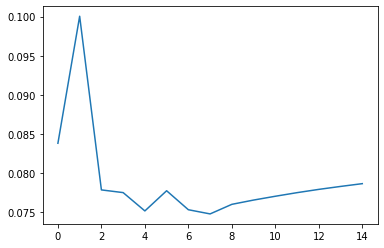

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(len(DNN.loss_list)), DNN.loss_list)

In [29]:
y_prad = DNN.predict(X_test)
# a = np.argmax(a,axis=1)
y_true = np.argmax(y_test_one_hot,axis=1)
y_true

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, ..., 7, 8, 9, 0, 1, 2, 3, 4, 5, 6])

In [30]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true,y_prad)

0.9847

In [31]:
y_train

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, ..., 9, 2, 9, 5, 1, 8, 3, 5, 6, 8],
      dtype=uint8)

In [ ]:
mini_X_train.shape

In [ ]:
mini_y_train.shape

In [ ]:
initializer=SimpleInitializer(sigma=0.01)